# 5. Multi-Layer Perceptron (MLP)

## Introduction

Implémentation d'un réseau de neurones inspiré du papier de Bengio et al. de 2003 [_A Neural Probabilistic Language Model_](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf).

On cherche toujours à construire un modèle de langue au niveau des caractères. Dans le papier ils ont un vocabulaire de 17000 mots et construisent un modèle de langue par mots, mais nous pouvons utiliser la même approche pour construire un modèle de langues par caractères.

Ils associent à chaque mot un vecteur dans un espace, par exemple à 30 dimensions. Ces vecteurs sont initialisés à des valeurs aléatoires et ensuite on fait apprendre au modèle, par rétropropagation et descente de gradient, la "meilleure" position du mot dans cet espace. Les mots similaires doivent être ensuite "proches" dans cet espace. On cherche à maximiser la _log-vraisemblance_.

Généralisation sur des phrases comme:

- "The cat is walking in the bedroom"
- "A dog was running in a room"
- "The cat is running in a room"
- "A dog is walking in a bedroom"
- "The dog was walking in the room"

Le schéma du réseau de Bengio 2003 est présenté ci-dessous. Avec un vocabulaire de 70000 mots, le réseau de neurones se compose d'une couche d'entrée, avec si on a un contexte de 3 mots précédents pour prédire le 4ème, 3x30 soit 90 neurones. La table C permet de récupérer le vecteur d'embedding de chaque mot de dimension 30, cette table est de taille 70000. La couche cachée est d'une taille qui est choisi arbitrairement (un hyperparamètre), par exemple 100. Le but va être de choisir le bon paramètre pour cette couche cachée. Chaque neurone est complètement connecté à tous les neurones de la couche d'entrée. La fonction non-linéaire utilisée en sortie est la tangente hyperbolique. La couche de sortie a 70000 neurones et est complètement connecté aux neurones (par ex. 100) de la couche cachée. La sortie se compose de logits qui seront transformés en probabilités par une fonction softmax (log -> exp -> normalisation). Optimisation des paramètres (poids et biais) par rétropropagation en maximisant la log-vraissemblance.

![Réseau de BengioY 2003](BengioY2003_network.png)

Source: <https://mines.paris/nlp/gfx/schemas/BengioY2003_network.png>

Dans la suite de ce notebook, nous allons construire un réseau de neurones similaire à ce lui présenté dans le papier, de type _Feed Forward Network_, permettant d'obtenir un modèle de langue au niveau caractères. Ce type de réseau est également appelé _Multi-Layer Perceptron_ même si les neurones utilisés ici ne sont pas similaires à ceux d'un perceptron.

## Données sources

Nous reprenons les 7223 mots du code civil, amenant 41 caractères différents dans notre vocabulaire, incluant le caractère spécial '`.`' indiquant le début ou la fin d'un mot. Les entiers associés à chaque caractères sont les _tokens_ qui seront manipulés par notre réseau.

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('civil_mots.txt', 'r').read().splitlines()
nb_words = len(words)
chars = sorted(list(set(''.join(words))))
nb_chars = len(chars) + 1  # On ajoute 1 pour EOS
ctoi = {c:i+1 for i,c in enumerate(chars)}
ctoi['.'] = 0
itoc = {i:s for s,i in ctoi.items()}
print(ctoi)
print(f"{nb_words=}")
print(f"{nb_chars=}")

{"'": 1, '-': 2, 'a': 3, 'b': 4, 'c': 5, 'd': 6, 'e': 7, 'f': 8, 'g': 9, 'h': 10, 'i': 11, 'j': 12, 'l': 13, 'm': 14, 'n': 15, 'o': 16, 'p': 17, 'q': 18, 'r': 19, 's': 20, 't': 21, 'u': 22, 'v': 23, 'w': 24, 'x': 25, 'y': 26, 'z': 27, 'à': 28, 'â': 29, 'ç': 30, 'è': 31, 'é': 32, 'ê': 33, 'ë': 34, 'î': 35, 'ï': 36, 'ô': 37, 'ù': 38, 'û': 39, 'œ': 40, '.': 0}
nb_words=7223
nb_chars=41


## Construction du jeu de données pour l'entraînement

### Fonction de construction

Nous créons une fonction `build_dataset` qui va permettre de construire le jeu d'entraînement à partir d'une liste de mots et d'une taille de contexte. Ce jeu d'entraînement sera composé des entrées `X` avec un nombre de caractères pour chaque entrée dépandant de la taille du contexte, et des réponses `Y` attendues (un caractère).

In [3]:
def build_dataset(words:list, context_size:int, verbose:bool=False):
    """Build the dataset of the neural net for training.

    Parameters:
        words: list of words of our data corpus
        context_size: how many characters we take to predict the next one
        verbose: print or not the inputs and labels during construction
    Returns:
        X: inputs to the neural net
        Y: labels
    """
    X, Y = [], []
    if verbose:
        nb_examples = 0
        nb_characters = 0
        nb_words = len(words)
    for w in words:
        if verbose:
            print(w)
            nb_characters += len(w)
        context = [0] * context_size
        for ch in w + '.':
            ix = ctoi[ch]
            X.append(context)
            Y.append(ix)
            if verbose:
                print(''.join(itoc[i] for i in context), '--->', itoc[ix])
                nb_examples += 1
            context = context[1:] + [ix] # crop and append
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    if verbose:
        print(X.shape, Y.shape)
        print(f"{nb_examples=}")
        print(f"{nb_characters=}")
        print(f"{nb_words=}")
    return X, Y

In [4]:
X, Y = build_dataset(words[40:45], 3, verbose=True)

acceptée
... ---> a
..a ---> c
.ac ---> c
acc ---> e
cce ---> p
cep ---> t
ept ---> é
pté ---> e
tée ---> .
acceptées
... ---> a
..a ---> c
.ac ---> c
acc ---> e
cce ---> p
cep ---> t
ept ---> é
pté ---> e
tée ---> s
ées ---> .
accessible
... ---> a
..a ---> c
.ac ---> c
acc ---> e
cce ---> s
ces ---> s
ess ---> i
ssi ---> b
sib ---> l
ibl ---> e
ble ---> .
accession
... ---> a
..a ---> c
.ac ---> c
acc ---> e
cce ---> s
ces ---> s
ess ---> i
ssi ---> o
sio ---> n
ion ---> .
accessoire
... ---> a
..a ---> c
.ac ---> c
acc ---> e
cce ---> s
ces ---> s
ess ---> o
sso ---> i
soi ---> r
oir ---> e
ire ---> .
torch.Size([51, 3]) torch.Size([51])
nb_examples=51
nb_characters=46
nb_words=5


In [5]:
X, Y = build_dataset(words[40:45], 10, verbose=True)

acceptée
.......... ---> a
.........a ---> c
........ac ---> c
.......acc ---> e
......acce ---> p
.....accep ---> t
....accept ---> é
...accepté ---> e
..acceptée ---> .
acceptées
.......... ---> a
.........a ---> c
........ac ---> c
.......acc ---> e
......acce ---> p
.....accep ---> t
....accept ---> é
...accepté ---> e
..acceptée ---> s
.acceptées ---> .
accessible
.......... ---> a
.........a ---> c
........ac ---> c
.......acc ---> e
......acce ---> s
.....acces ---> s
....access ---> i
...accessi ---> b
..accessib ---> l
.accessibl ---> e
accessible ---> .
accession
.......... ---> a
.........a ---> c
........ac ---> c
.......acc ---> e
......acce ---> s
.....acces ---> s
....access ---> i
...accessi ---> o
..accessio ---> n
.accession ---> .
accessoire
.......... ---> a
.........a ---> c
........ac ---> c
.......acc ---> e
......acce ---> s
.....acces ---> s
....access ---> o
...accesso ---> i
..accessoi ---> r
.accessoir ---> e
accessoire ---> .
torch.Size([51, 10]) torch.Size

### Construction du jeu d'entraînement complet

Les mots du code civil générent un jeu d'entraînement avec les entrées `X` de dimension 2 de forme (67652, 3), soit 67652 contextes de 3 caractères différents et pour les labels `Y` 67652 caractères suivants.

In [6]:
context_size = 3
X, Y = build_dataset(words, context_size)
print("X.shape =", X.shape)
print("Y.shape =", Y.shape)
print(X[:5])
print(Y[:5])

X.shape = torch.Size([67652, 3])
Y.shape = torch.Size([67652])
tensor([[0, 0, 0],
        [0, 0, 3],
        [0, 0, 0],
        [0, 0, 3],
        [0, 3, 4]])
tensor([3, 0, 3, 4, 3])


Pour la suite de la discussion, nous allons uniquement prendre 5 mots, représentant 53 exemples, afin d'avoir un jeu de données `Xd` et `Yd` plus petit qui se prête mieux à l'affichage:

In [7]:
context_size = 3
Xd, Yd = build_dataset(words[5:10], context_size)
print("Xd.shape =", Xd.shape)
print("Yd.shape =", Yd.shape)
print(Xd)
print(Yd)

Xd.shape = torch.Size([53, 3])
Yd.shape = torch.Size([53])
tensor([[ 0,  0,  0],
        [ 0,  0,  3],
        [ 0,  3,  4],
        [ 3,  4,  3],
        [ 4,  3, 15],
        [ 3, 15,  6],
        [15,  6, 16],
        [ 6, 16, 15],
        [16, 15, 15],
        [15, 15, 32],
        [ 0,  0,  0],
        [ 0,  0,  3],
        [ 0,  3,  4],
        [ 3,  4,  3],
        [ 4,  3, 15],
        [ 3, 15,  6],
        [15,  6, 16],
        [ 6, 16, 15],
        [16, 15, 15],
        [15, 15, 32],
        [15, 32,  7],
        [ 0,  0,  0],
        [ 0,  0,  3],
        [ 0,  3,  4],
        [ 3,  4,  3],
        [ 4,  3, 15],
        [ 3, 15,  6],
        [15,  6, 16],
        [ 6, 16, 15],
        [16, 15, 15],
        [15, 15, 32],
        [15, 32,  7],
        [32,  7, 20],
        [ 0,  0,  0],
        [ 0,  0,  3],
        [ 0,  3,  4],
        [ 3,  4,  3],
        [ 4,  3, 15],
        [ 3, 15,  6],
        [15,  6, 16],
        [ 6, 16, 15],
        [16, 15, 15],
        [15, 15, 

Nous avons donc `Xd` qui représentent des suites de trois tokens pour lesquels nous devrions obtenir à la fin les `Yd` correspondants.

## Discussion: construction du réseau de neurones

### Création de la matrice d'embeddings

Cette matrice est ce qui est appelé la _lookup table_ dans [Bengio et al. 2003](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf). Elle sera de taille `nb_chars x e_dims`, où `nb_chars` est le nombre de caractères différents de notre dataset (41) et `e_dims` le nombre de dimensions (ici 2) que nous choisirons pour représenter chaque caractère dans ce nouvel espace. Nous initialisons ici les valeurs de cette table de manière aléatoire.

In [8]:
e_dims = 2  # Dimensions des embeddings
C = torch.randn((nb_chars, e_dims))
print(C)

tensor([[ 0.4806,  0.9659],
        [-0.9354,  0.8722],
        [ 1.9186,  1.1885],
        [ 0.1595, -0.9922],
        [-0.3260,  0.9572],
        [ 2.2385, -1.2704],
        [-0.2007, -1.0860],
        [ 1.1423, -0.2115],
        [-0.7590, -0.6401],
        [ 0.0339, -0.4439],
        [-0.3950, -0.5841],
        [-0.6752, -0.6698],
        [ 0.2760,  0.0204],
        [ 1.0637,  1.7657],
        [-0.4892, -0.0236],
        [-0.4793,  0.3979],
        [-0.2206,  0.3598],
        [ 1.2669,  1.5495],
        [-0.8553,  0.5060],
        [ 1.1250, -1.6645],
        [ 0.8648, -0.6060],
        [ 0.8861,  0.9204],
        [-1.0055,  1.5119],
        [-1.2406,  0.1779],
        [ 0.8390, -0.1560],
        [ 1.1340,  1.0290],
        [-0.5181, -0.3230],
        [ 0.4742,  0.2750],
        [-0.0866,  0.3084],
        [-0.1322, -0.6673],
        [-0.4096,  1.3299],
        [ 1.5092, -0.4951],
        [-0.0418,  1.0244],
        [-0.3153, -0.5744],
        [ 0.3304, -0.9862],
        [-1.9956, -1

Pour utiliser cette "_lookup table_" sous la forme d'une matrice, on peut l'indexer avec le numéro du caractère dont on souhaite obtenir l'embedding, par exemple ici à partir du token `5` correspondant au caractère `c`:

In [9]:
emb_char_c = C[5]  # 5: token correspondant à 'c'
print(emb_char_c)

tensor([ 2.2385, -1.2704])


On peut également remarquer que l'on peut indexer un caractère à partir d'un vecteur "one-hot" correspondant au même caractère, en multipliant la matrice d'embeddings par ce vecteur:

In [10]:
c_one_hot = F.one_hot(torch.tensor(5), num_classes=nb_chars).float()
print(f"{c_one_hot=}")

c_one_hot=tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.])


In [11]:
c_one_hot @ C

tensor([ 2.2385, -1.2704])

La première couche linéaire de ce réseau de neurones, composé de cette matrice C, va être activée avec les indices des caractères.

L'indexation avec des tenseurs Pytorch est très flexible, ce qui permet de récupérer plusiers lignes, par exemple correspondant à la suite de lettres c, a, b (soit 5,3,4):

In [12]:
C[[5,3,4]]

tensor([[ 2.2385, -1.2704],
        [ 0.1595, -0.9922],
        [-0.3260,  0.9572]])

In [13]:
C[[ctoi['c'], ctoi['a'], ctoi['b']]]

tensor([[ 2.2385, -1.2704],
        [ 0.1595, -0.9922],
        [-0.3260,  0.9572]])

On peut également indexer avec un tenseur:

In [14]:
C[torch.tensor([5,3,4])]

tensor([[ 2.2385, -1.2704],
        [ 0.1595, -0.9922],
        [-0.3260,  0.9572]])

Ce tenseur peut être multi-dimensionnel, comme par exemple `Xd`:

In [15]:
C[Xd]

tensor([[[ 0.4806,  0.9659],
         [ 0.4806,  0.9659],
         [ 0.4806,  0.9659]],

        [[ 0.4806,  0.9659],
         [ 0.4806,  0.9659],
         [ 0.1595, -0.9922]],

        [[ 0.4806,  0.9659],
         [ 0.1595, -0.9922],
         [-0.3260,  0.9572]],

        [[ 0.1595, -0.9922],
         [-0.3260,  0.9572],
         [ 0.1595, -0.9922]],

        [[-0.3260,  0.9572],
         [ 0.1595, -0.9922],
         [-0.4793,  0.3979]],

        [[ 0.1595, -0.9922],
         [-0.4793,  0.3979],
         [-0.2007, -1.0860]],

        [[-0.4793,  0.3979],
         [-0.2007, -1.0860],
         [-0.2206,  0.3598]],

        [[-0.2007, -1.0860],
         [-0.2206,  0.3598],
         [-0.4793,  0.3979]],

        [[-0.2206,  0.3598],
         [-0.4793,  0.3979],
         [-0.4793,  0.3979]],

        [[-0.4793,  0.3979],
         [-0.4793,  0.3979],
         [-0.0418,  1.0244]],

        [[ 0.4806,  0.9659],
         [ 0.4806,  0.9659],
         [ 0.4806,  0.9659]],

        [[ 0.4806,  0

In [16]:
C[Xd].shape

torch.Size([53, 3, 2])

Ce qui nous permet de créer tous les embeddings sur notre jeu de données de "démo", un tenseur d'ordre 3 de dimensions $53\times 3\times 2$. 

In [17]:
emb = C[Xd]
emb.shape

torch.Size([53, 3, 2])

## Création de la couche cachée

La couche cachée sera composée d'une couche avec `context_size * e_dims` entrées et un nombre de neurones `hidden_layer_size` à définir (prenons ici 100), avec pour chaque neurone un poids et un biais, poids et biais qui seront définis dans une matrice `W1` et un vecteur `b1`:

In [18]:
hidden_layer_size = 100
W1 = torch.randn((context_size * e_dims, hidden_layer_size))
b1 = torch.randn(hidden_layer_size)
W1.shape, b1.shape

(torch.Size([6, 100]), torch.Size([100]))

Nous souhaiterions donc maintenant multiplier les entrées par les poids et ajouter les biais, ce qui ne va pas être possibles car les tenseurs ne sont pas compatibles.

In [19]:
# emb @ W1 + b1  # Décommenter pour voir l'erreur

Il faudrait passer pour `emb` d'une forme `[53, 3, 2]` à une forme `[53, 6]`.

On peut le faire avec PyTorch en concaténant en dimension 1 avec [`cat`](https://pytorch.org/docs/main/generated/torch.cat.html): 

In [20]:
torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], 1).shape

torch.Size([53, 6])

Mais cette approche n'est pas très propre car difficilement généralisable. On peut également utiliser [`unbind`](https://pytorch.org/docs/stable/generated/torch.unbind.html) qui est plus simple:

In [21]:
torch.cat(torch.unbind(emb, 1), 1).shape

torch.Size([53, 6])

Mais il y a une approche plus efficace consistant à utiliser la méthode [`view()`](https://pytorch.org/docs/stable/generated/torch.Tensor.view.html) d'un tenseur, permettant de "réorganiser" les éléments d'un tenseur selon différentes formes et dimensions, à condition que le nombre d'éléments soit identique:

In [22]:
a = torch.arange(18)
a

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])

In [23]:
a.shape

torch.Size([18])

In [24]:
a.view(2, 9)

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8],
        [ 9, 10, 11, 12, 13, 14, 15, 16, 17]])

In [25]:
a.view(9, 2)

tensor([[ 0,  1],
        [ 2,  3],
        [ 4,  5],
        [ 6,  7],
        [ 8,  9],
        [10, 11],
        [12, 13],
        [14, 15],
        [16, 17]])

In [26]:
a.view(3, 3, 2)

tensor([[[ 0,  1],
         [ 2,  3],
         [ 4,  5]],

        [[ 6,  7],
         [ 8,  9],
         [10, 11]],

        [[12, 13],
         [14, 15],
         [16, 17]]])

In [27]:
# a.untyped_storage()

Avec nos embeddings `emb`, il est donc possible d'utiliser `view` ainsi:

In [28]:
emb.view(53, 6)

tensor([[ 0.4806,  0.9659,  0.4806,  0.9659,  0.4806,  0.9659],
        [ 0.4806,  0.9659,  0.4806,  0.9659,  0.1595, -0.9922],
        [ 0.4806,  0.9659,  0.1595, -0.9922, -0.3260,  0.9572],
        [ 0.1595, -0.9922, -0.3260,  0.9572,  0.1595, -0.9922],
        [-0.3260,  0.9572,  0.1595, -0.9922, -0.4793,  0.3979],
        [ 0.1595, -0.9922, -0.4793,  0.3979, -0.2007, -1.0860],
        [-0.4793,  0.3979, -0.2007, -1.0860, -0.2206,  0.3598],
        [-0.2007, -1.0860, -0.2206,  0.3598, -0.4793,  0.3979],
        [-0.2206,  0.3598, -0.4793,  0.3979, -0.4793,  0.3979],
        [-0.4793,  0.3979, -0.4793,  0.3979, -0.0418,  1.0244],
        [ 0.4806,  0.9659,  0.4806,  0.9659,  0.4806,  0.9659],
        [ 0.4806,  0.9659,  0.4806,  0.9659,  0.1595, -0.9922],
        [ 0.4806,  0.9659,  0.1595, -0.9922, -0.3260,  0.9572],
        [ 0.1595, -0.9922, -0.3260,  0.9572,  0.1595, -0.9922],
        [-0.3260,  0.9572,  0.1595, -0.9922, -0.4793,  0.3979],
        [ 0.1595, -0.9922, -0.4793,  0.3

ou avec la valeur spéciale `-1` qui permet de ne pas avoir à spécifier la taille du premier ordre du tenseur:

In [29]:
emb.view(-1, 6)

tensor([[ 0.4806,  0.9659,  0.4806,  0.9659,  0.4806,  0.9659],
        [ 0.4806,  0.9659,  0.4806,  0.9659,  0.1595, -0.9922],
        [ 0.4806,  0.9659,  0.1595, -0.9922, -0.3260,  0.9572],
        [ 0.1595, -0.9922, -0.3260,  0.9572,  0.1595, -0.9922],
        [-0.3260,  0.9572,  0.1595, -0.9922, -0.4793,  0.3979],
        [ 0.1595, -0.9922, -0.4793,  0.3979, -0.2007, -1.0860],
        [-0.4793,  0.3979, -0.2007, -1.0860, -0.2206,  0.3598],
        [-0.2007, -1.0860, -0.2206,  0.3598, -0.4793,  0.3979],
        [-0.2206,  0.3598, -0.4793,  0.3979, -0.4793,  0.3979],
        [-0.4793,  0.3979, -0.4793,  0.3979, -0.0418,  1.0244],
        [ 0.4806,  0.9659,  0.4806,  0.9659,  0.4806,  0.9659],
        [ 0.4806,  0.9659,  0.4806,  0.9659,  0.1595, -0.9922],
        [ 0.4806,  0.9659,  0.1595, -0.9922, -0.3260,  0.9572],
        [ 0.1595, -0.9922, -0.3260,  0.9572,  0.1595, -0.9922],
        [-0.3260,  0.9572,  0.1595, -0.9922, -0.4793,  0.3979],
        [ 0.1595, -0.9922, -0.4793,  0.3

De manière générique, nous pouvons donc écrire:

In [30]:
emb.view(-1, context_size * e_dims)

tensor([[ 0.4806,  0.9659,  0.4806,  0.9659,  0.4806,  0.9659],
        [ 0.4806,  0.9659,  0.4806,  0.9659,  0.1595, -0.9922],
        [ 0.4806,  0.9659,  0.1595, -0.9922, -0.3260,  0.9572],
        [ 0.1595, -0.9922, -0.3260,  0.9572,  0.1595, -0.9922],
        [-0.3260,  0.9572,  0.1595, -0.9922, -0.4793,  0.3979],
        [ 0.1595, -0.9922, -0.4793,  0.3979, -0.2007, -1.0860],
        [-0.4793,  0.3979, -0.2007, -1.0860, -0.2206,  0.3598],
        [-0.2007, -1.0860, -0.2206,  0.3598, -0.4793,  0.3979],
        [-0.2206,  0.3598, -0.4793,  0.3979, -0.4793,  0.3979],
        [-0.4793,  0.3979, -0.4793,  0.3979, -0.0418,  1.0244],
        [ 0.4806,  0.9659,  0.4806,  0.9659,  0.4806,  0.9659],
        [ 0.4806,  0.9659,  0.4806,  0.9659,  0.1595, -0.9922],
        [ 0.4806,  0.9659,  0.1595, -0.9922, -0.3260,  0.9572],
        [ 0.1595, -0.9922, -0.3260,  0.9572,  0.1595, -0.9922],
        [-0.3260,  0.9572,  0.1595, -0.9922, -0.4793,  0.3979],
        [ 0.1595, -0.9922, -0.4793,  0.3

Nous pouvons maintenant implémenter la couche cachée `h` complètement:

In [31]:
h = torch.tanh(emb.view(-1, context_size*e_dims) @ W1 + b1)
h

tensor([[ 0.4931,  0.9997, -0.4131,  ..., -0.9919,  0.2336,  0.4416],
        [-0.7059,  0.9476, -0.9881,  ..., -0.9353,  0.6110, -0.2495],
        [ 0.7830,  0.8349,  0.9091,  ..., -0.7906, -0.6847,  0.9962],
        ...,
        [ 0.8753,  0.2654, -0.6717,  ..., -0.1456, -0.2736,  0.8699],
        [ 0.7239, -0.0967, -0.9465,  ..., -0.8542,  0.5216, -0.9400],
        [ 0.4366,  0.9808, -0.9875,  ..., -0.1445, -0.8273,  0.1011]])

### Couche de sortie

De manière similaire à la couche cachée la couche de sortie va se composer d'une matrice de poids `W2` et d'un vecteur de biais `b2`:

In [32]:
W2 = torch.randn((hidden_layer_size, nb_chars))
b2 = torch.randn(nb_chars)
W2.shape, b2.shape

(torch.Size([100, 41]), torch.Size([41]))

Le calcul des _logits_ de sortie de la couche de sortie s'obtiennent en multipliant les valeurs de la couche cachée par les poids `W2` et en ajoutant les biais:

In [33]:
logits = h @ W2 + b2
logits.shape

torch.Size([53, 41])

Pour obtenir des probabilités à partir des logits (interprétés comme des logs), on utilise notre fonction _softmax_:

In [34]:
counts = logits.exp()
prob = counts / counts.sum(1, keepdims=True)

Nous pouvons vérifier que la somme de ces probabilités est également à 1:

In [35]:
prob[0].sum()

tensor(1.0000)

À partir de ces probabilités, nous voulons maintenant obtenir la probabilité affectée à chacun des caractères attendus de `Yd`:

In [36]:
Yd

tensor([ 3,  4,  3, 15,  6, 16, 15, 15, 32,  0,  3,  4,  3, 15,  6, 16, 15, 15,
        32,  7,  0,  3,  4,  3, 15,  6, 16, 15, 15, 32,  7, 20,  0,  3,  4,  3,
        15,  6, 16, 15, 15, 32, 20,  0,  3,  4,  3, 15,  6, 16, 15, 20,  0])

`prob` étant d'ordre 2, nous devons donc indexer par le "numéro" de l'exemple (`torch.arange(53)` car il y a 53 exemples dans `Yd`) et le numéro du token, soit:

In [37]:
prob[torch.arange(53), Yd]

tensor([1.3885e-09, 2.0777e-06, 9.6970e-03, 4.8020e-15, 6.1410e-06, 8.1274e-15,
        1.1853e-01, 8.5158e-09, 2.0254e-05, 1.6990e-04, 1.3885e-09, 2.0777e-06,
        9.6970e-03, 4.8020e-15, 6.1410e-06, 8.1274e-15, 1.1853e-01, 8.5158e-09,
        2.0254e-05, 5.7130e-06, 1.3612e-06, 1.3885e-09, 2.0777e-06, 9.6970e-03,
        4.8020e-15, 6.1410e-06, 8.1274e-15, 1.1853e-01, 8.5158e-09, 2.0254e-05,
        5.7130e-06, 6.4163e-10, 2.2806e-05, 1.3885e-09, 2.0777e-06, 9.6970e-03,
        4.8020e-15, 6.1410e-06, 8.1274e-15, 1.1853e-01, 8.5158e-09, 2.0254e-05,
        1.5092e-14, 9.4455e-08, 1.3885e-09, 2.0777e-06, 9.6970e-03, 4.8020e-15,
        6.1410e-06, 8.1274e-15, 1.1853e-01, 1.0905e-14, 1.0875e-09])

Ou de manière générique en utilisant `size` pour obtenir la taille de `Yd`:

In [38]:
prob[torch.arange(Yd.size(0)), Yd]

tensor([1.3885e-09, 2.0777e-06, 9.6970e-03, 4.8020e-15, 6.1410e-06, 8.1274e-15,
        1.1853e-01, 8.5158e-09, 2.0254e-05, 1.6990e-04, 1.3885e-09, 2.0777e-06,
        9.6970e-03, 4.8020e-15, 6.1410e-06, 8.1274e-15, 1.1853e-01, 8.5158e-09,
        2.0254e-05, 5.7130e-06, 1.3612e-06, 1.3885e-09, 2.0777e-06, 9.6970e-03,
        4.8020e-15, 6.1410e-06, 8.1274e-15, 1.1853e-01, 8.5158e-09, 2.0254e-05,
        5.7130e-06, 6.4163e-10, 2.2806e-05, 1.3885e-09, 2.0777e-06, 9.6970e-03,
        4.8020e-15, 6.1410e-06, 8.1274e-15, 1.1853e-01, 8.5158e-09, 2.0254e-05,
        1.5092e-14, 9.4455e-08, 1.3885e-09, 2.0777e-06, 9.6970e-03, 4.8020e-15,
        6.1410e-06, 8.1274e-15, 1.1853e-01, 1.0905e-14, 1.0875e-09])

### Fonction de perte: cross-entropy

Nous pouvons maintenant estimer la "qualité" de notre modèle partiel (sur 53 exemples) avec notre fonction de perte:

In [39]:
loss = -prob[torch.arange(Yd.size(0)), Yd].log().mean()
loss

tensor(16.6951)

Jusqu'à ce point, le réseau calcule des "logits", qui sont passés dans un Softmax pour obtenir des probabilités. La "Negative Log Likelihood" est calculée manuellement.
Le calcul manuel peut-être remplacé par la "cross-entropy":

1.  Plus efficace (opérations fusionnées, moins de tenseurs intermédiaires).
2.  Plus simple pour la rétropropagation (backward pass).
3.  **Stabilité numérique:** la "cross-entropy" gère mieux les très grands nombres (qui causeraient des `NaN` avec une exponentielle naïve) en soustrayant le maximum des logits avant le calcul.

La methode [`cross_entropy`](https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html) de Pytorch permet de calculer plus efficacement le loss, tout en donnant le même résultat:

In [40]:
loss = F.cross_entropy(logits, Yd)
loss

tensor(16.6951)

Pour illustrer le fait d'utiliser des probabilités examinons ces deux exemples:

In [41]:
logits = torch.tensor([-2, -3, 0, 5])
counts = logits.exp()
probs = counts / counts.sum()
probs

tensor([9.0466e-04, 3.3281e-04, 6.6846e-03, 9.9208e-01])

In [42]:
logits = torch.tensor([-100, -3, 0, 100])
counts = logits.exp()
probs = counts / counts.sum()
probs

tensor([0., 0., 0., nan])

## Réseau complet "Feed Forward Netword"

### Données

In [43]:
words = open('civil_mots.txt', 'r').read().splitlines()
nb_words = len(words)
chars = sorted(list(set(''.join(words))))
EOS = '.'
nb_chars = len(chars) + 1  # On ajoute 1 pour EOS
ctoi = {c:i+1 for i,c in enumerate(chars)}
ctoi[EOS] = 0
itoc = {i:s for s,i in ctoi.items()}

### Jeux d'entraînement, de développement et de test

In [44]:
# 80%, 10%, 10%
import random

random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1], context_size=context_size)
Xdev, Ydev = build_dataset(words[n1:n2], context_size=context_size)
Xte, Yte = build_dataset(words[n2:], context_size=context_size)

### Hyperparamètres

In [45]:
context_size = 3
e_dims = 2  # Dimensions des embeddings
hidden_layer_size = 100
mini_batch_size = 32
steps = 200000
seed = 2147483647

### Architecture

In [46]:
g = torch.Generator().manual_seed(seed) # for reproducibility
C = torch.randn((nb_chars, e_dims), generator=g)
W1 = torch.randn((context_size * e_dims, hidden_layer_size), generator=g)
b1 = torch.randn(hidden_layer_size, generator=g)
W2 = torch.randn((hidden_layer_size, nb_chars), generator=g)
b2 = torch.randn(nb_chars, generator=g)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

In [47]:
sum(p.nelement() for p in parameters) # number of parameters in total

4923

## Entraînement

In [48]:
lossi = []
stepi = []

In [49]:
for i in range(steps):
    # mini-batch construct
    ix = torch.randint(0, Xtr.shape[0], (mini_batch_size,))
  
    # forward pass
    emb = C[Xtr[ix]] # (mini_batch_size, context_size, e_dims)
    h = torch.tanh(emb.view(-1, context_size * e_dims) @ W1 + b1) # (mini_batch_size, hidden_layer_size)
    logits = h @ W2 + b2 # (mini_batch_size, nb_chars)
    loss = F.cross_entropy(logits, Ytr[ix])
  
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
  
    # update
    lr = 0.16 if i < 100000 else 0.016
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    stepi.append(i)
    lossi.append(loss.log10().item())

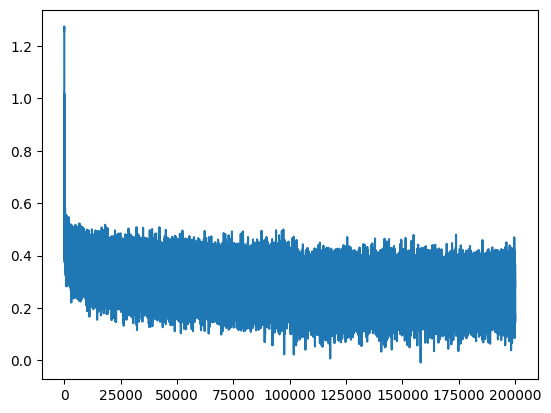

In [50]:
plt.plot(stepi, lossi)

In [51]:
emb = C[Xtr] # (batch_size, context_size , e_dims)
h = torch.tanh(emb.view(-1, context_size * e_dims) @ W1 + b1) # (batch_size, hidden_layer_size)
logits = h @ W2 + b2 # (batch_size, nb_chars)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(1.8583, grad_fn=<NllLossBackward0>)

In [52]:
emb = C[Xdev] # (batch_size, context_size , e_dims)
h = torch.tanh(emb.view(-1, context_size * e_dims) @ W1 + b1) # (batch_size, hidden_layer_size)
logits = h @ W2 + b2 # (batch_size, nb_chars)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(1.9103, grad_fn=<NllLossBackward0>)

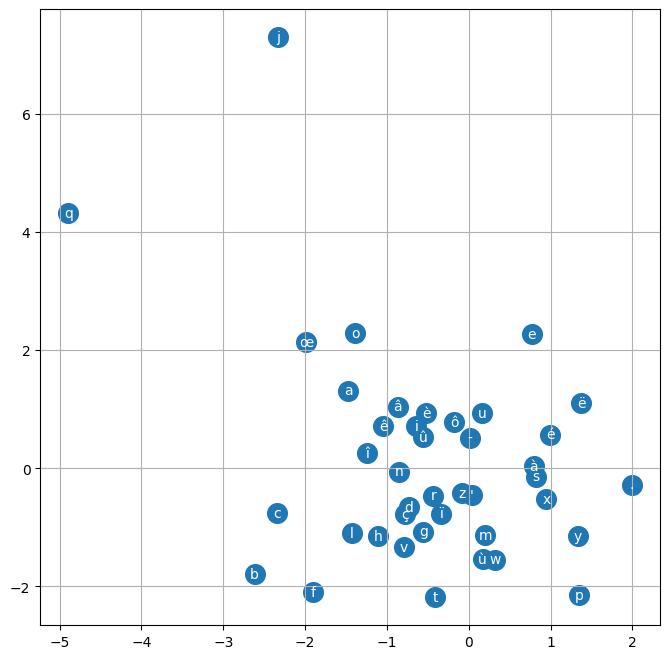

In [53]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itoc[i], ha="center", va="center", color='white')
plt.grid('minor')

## Utilisation du modèle: génération de mots

In [54]:
context = [0] * context_size
C[torch.tensor([context])].shape

torch.Size([1, 3, 2])

In [55]:
# sample from the model
g = torch.Generator().manual_seed(seed)

for _ in range(20):
    out = []
    context = [0] * context_size # initialize with all ...
    while True:
        emb = C[torch.tensor([context])] # (1, context_size, e_dims)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        if ix == 0:
            break
        out.append(ix)
    print(''.join(itoc[i] for i in out))

écraine
mécicée
mutes
reure
moliaux
achis
rectues
partépépéries
dev
plêquêtre
accude
prement
angentrapterission
prange-prodétaluser
édomilatectivecouraclementéroies
lersé
sai
craie
hre
decables


## Exercice

Modifier les hyperparamètres de l'entraînement pour battre le score courant de test.

In [56]:
emb = C[Xte] # (batch_size, context_size , e_dims)
h = torch.tanh(emb.view(-1, context_size * e_dims) @ W1 + b1) # (batch_size, hidden_layer_size)
logits = h @ W2 + b2 # (batch_size, nb_chars)
loss = F.cross_entropy(logits, Yte)
loss

tensor(1.9492, grad_fn=<NllLossBackward0>)

## Post-cours: détermination d'un "bon" lr

In [57]:
g = torch.Generator().manual_seed(seed) # for reproducibility
C = torch.randn((nb_chars, e_dims), generator=g)
W1 = torch.randn((context_size * e_dims, hidden_layer_size), generator=g)
b1 = torch.randn(hidden_layer_size, generator=g)
W2 = torch.randn((hidden_layer_size, nb_chars), generator=g)
b2 = torch.randn(nb_chars, generator=g)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre
lossi = []
stepi = []
lri = []
lrei = []

for i in range(1000):
    # mini-batch construct
    ix = torch.randint(0, Xtr.shape[0], (mini_batch_size,))
  
    # forward pass
    emb = C[Xtr[ix]] # (mini_batch_size, context_size, e_dims)
    h = torch.tanh(emb.view(-1, context_size * e_dims) @ W1 + b1) # (mini_batch_size, hidden_layer_size)
    logits = h @ W2 + b2 # (mini_batch_size, nb_chars)
    loss = F.cross_entropy(logits, Ytr[ix])
  
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
  
    # update
    lr = lrs[i]
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    lrei.append(lre[i])
    lri.append(lr)
    stepi.append(i)
    lossi.append(loss.log10().item())

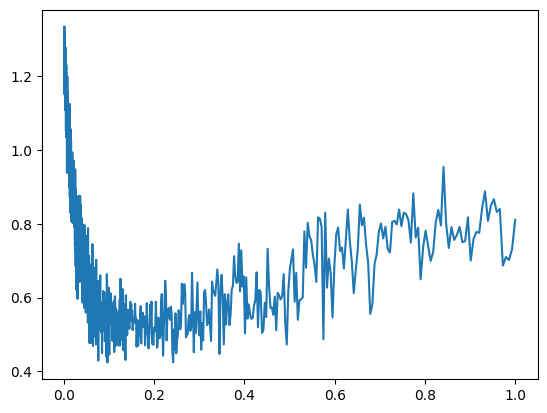

In [58]:
plt.plot(lri, lossi)

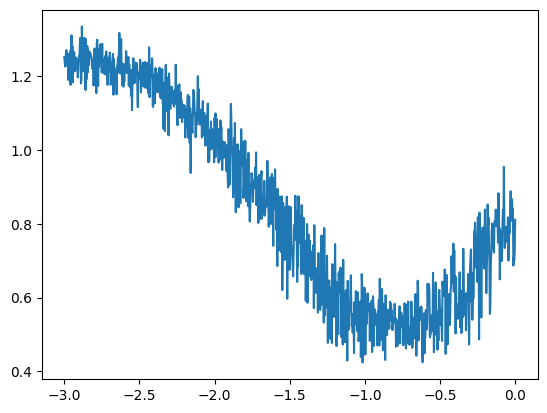

In [59]:
plt.plot(lrei, lossi)